In [2]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
from keras.callbacks import *

import tensorflow as tf

import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [3]:
dataset_path = '../data/dataset-dirigenti-split.pkl'

with open(dataset_path, 'rb') as f:
    train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = pickle.load(f)

## Tokenize the Dataset

In [4]:
samples = np.concatenate([train_samples,val_samples, test_samples])
samples.shape

(138043,)

In [5]:
labels = np.concatenate([train_labels, val_labels, test_labels])
labels.shape

(138043,)

In [6]:
max_features = 10000

In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(samples)

In [9]:
with open('id_word.tsv','w') as f:
    for word, ids in tokenizer.word_index.items():
        f.write('{}\t{}\n'.format(ids,word))

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_samples)
val_sequences = tokenizer.texts_to_sequences(val_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

In [11]:
for s in test_sequences[:2]:
    print(s) 

[2345, 1617, 3926, 7, 180, 98, 961, 2298, 1, 5495, 3735, 264, 1414, 4, 12, 567, 21, 264, 2020]
[203, 56, 14, 1, 235, 461, 925, 1726, 2, 1742, 4, 506, 1, 221, 24, 353, 248, 4, 707, 8, 878, 9, 140, 6593, 20, 27, 8, 6239, 982, 4698, 350]


Convert labels to ids

In [12]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [13]:
list(labels_to_index.items())[:5]

[('01943', 0),
 ('DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI', 1),
 ('DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI', 2),
 ('DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ', 3),
 ('01946', 4)]

In [14]:
len(labels_to_index)

20

In [15]:
encoded_train_labels = [labels_to_index[l] for l in train_labels]
encoded_val_labels = [labels_to_index[l] for l in val_labels]
encoded_test_labels = [labels_to_index[l] for l in test_labels]

In [16]:
encoded_train_labels[:10]

[0, 12, 1, 1, 9, 15, 2, 16, 19, 18]

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [17]:
from keras.preprocessing import sequence

In [18]:
print('max length of objects {}'.format(max(map(len, train_sequences))))

max length of objects 150


#### Maximum Sequence Length

for initial test we use the first 100 words

In [19]:
maxlen = 150

In [20]:
x_train_pad = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_val_pad = sequence.pad_sequences(val_sequences, maxlen=maxlen)
x_test_pad = sequence.pad_sequences(test_sequences, maxlen=maxlen)

In [21]:
x_train_pad.shape

(99390, 150)

One-hot encoding for input

In [22]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float16)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [23]:
x_train = vectorize_sequences(train_sequences, max_features)
x_val = vectorize_sequences(val_sequences, max_features)
x_test = vectorize_sequences(test_sequences, max_features)

One hot encoding for the labels

In [24]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [25]:
y_train = to_one_hot(encoded_train_labels)
y_val = to_one_hot(encoded_val_labels)
y_test = to_one_hot(encoded_test_labels)

In [26]:
y_train.shape

(99390, 20)

### Plotting Results Helpers

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2, step=0.2))
    plt.xticks(np.arange(0,len(loss), step=1))
    plt.legend()
    plt.show()

In [29]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1, step=0.05))
    plt.xticks(np.arange(0,len(acc), step=1))
    plt.legend()
    plt.show()

In [30]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

## Build the Models

We take into account:
- a base model that uses dropout
- an evaluation of LSTM and GRU models da uses dropout, reverse the text order and uses Bidirectional-LSTM 

In [38]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
def build_model_cnn(embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen, name='embed'))
    model.add(layers.Conv1D(16, 5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(16, 5, activation='relu'))
    model.add(layers.Bidirectional(layers.GRU(64, activation='relu',
                         dropout= 0.5,
                         recurrent_dropout = 0.1,
                         return_sequences=False)))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [31]:
def build_model_lstm(neurons, embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen, name='embed'))
    model.add(
#         layers.Bidirectional(
        layers.GRU(neurons, activation='relu',
                         dropout= 0.1,
                         recurrent_dropout = 0.2,
                         return_sequences=True))
#              )
#     model.add(layers.BatchNormalization())
    model.add(layers.GRU(neurons, activation='relu',
                     dropout= 0.1,
                     recurrent_dropout = 0.2,
                     return_sequences=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [39]:
model_dropout = build_model_dropout(256)

In [40]:
history_dropout = model_dropout.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=20, batch_size=256, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/20
99390/99390 [==============================] - 9s 89us/step - loss: 1.2866 - acc: 0.5953 - val_loss: 0.5681 - val_acc: 0.8078
Epoch 2/20
99390/99390 [==============================] - 8s 82us/step - loss: 0.6252 - acc: 0.7932 - val_loss: 0.4800 - val_acc: 0.8358
Epoch 3/20
99390/99390 [==============================] - 8s 82us/step - loss: 0.4784 - acc: 0.8382 - val_loss: 0.4502 - val_acc: 0.8462
Epoch 4/20
99390/99390 [==============================] - 8s 81us/step - loss: 0.3996 - acc: 0.8648 - val_loss: 0.4374 - val_acc: 0.8519
Epoch 5/20
99390/99390 [==============================] - 8s 81us/step - loss: 0.3472 - acc: 0.8827 - val_loss: 0.4336 - val_acc: 0.8561
Epoch 6/20
99390/99390 [==============================] - 8s 81us/step - loss: 0.3033 - acc: 0.8961 - val_loss: 0.4419 - val_acc: 0.8562
Epoch 7/20
99390/99390 [==============================] - 8s 81us/step - loss: 0.2791 - acc: 0.9058 - val_loss: 0.4367 - val_acc

In [ ]:
%xdel model_dropout

In [ ]:
import gc
gc.collect()

In [ ]:
model_cnn = build_model_cnn(64)

In [33]:
from keras.callbacks import ReduceLROnPlateau

In [35]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
]

In [ ]:
history_cnn = model_cnn.fit(x=x_train_pad, y=y_train,  validation_data=(x_val_pad, y_val),
                   epochs=20, batch_size=256)

In [ ]:
%xdel model_cnn

In [36]:
model_lstm = build_model_lstm(64,64)
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 150, 64)           640000    
_________________________________________________________________
gru_1 (GRU)                  (None, 150, 64)           24768     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 690,836
Trainable params: 690,836
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_lstm = model_lstm.fit(x=x_train_pad, y=y_train,  validation_data=(x_val_pad, y_val),
                   epochs=20, batch_size=256, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/20
99390/99390 [==============================] - 117s 1ms/step - loss: 2.0309 - acc: 0.3699 - val_loss: 1.1040 - val_acc: 0.6554
Epoch 2/20
99390/99390 [==============================] - 113s 1ms/step - loss: 0.9700 - acc: 0.6816 - val_loss: 0.7618 - val_acc: 0.7505
Epoch 3/20
99390/99390 [==============================] - 113s 1ms/step - loss: 0.7266 - acc: 0.7564 - val_loss: 0.6666 - val_acc: 0.7771
Epoch 4/20
99390/99390 [==============================] - 114s 1ms/step - loss: 0.6119 - acc: 0.7916 - val_loss: 0.6103 - val_acc: 0.7943
Epoch 5/20
99390/99390 [==============================] - 117s 1ms/step - loss: 0.5439 - acc: 0.8127 - val_loss: 0.5861 - val_acc: 0.8066
Epoch 6/20
99390/99390 [==============================] - 116s 1ms/step - loss: 0.4962 - acc: 0.8283 - val_loss: 0.5749 - val_acc: 0.8082
Epoch 7/20
99390/99390 [==============================] - 115s 1ms/step - loss: 0.4584 - acc: 0.8415 - val_loss: 0.5700 - 

In [ ]:
%xdel model_lstm

### Printing The Loss

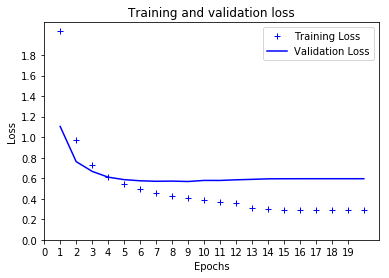

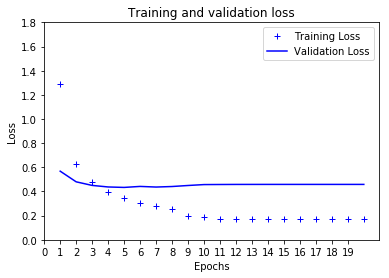

In [41]:
chart_loss(history_lstm)
chart_loss(history_dropout)

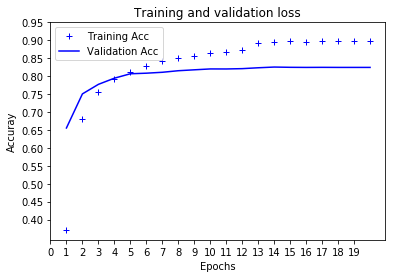

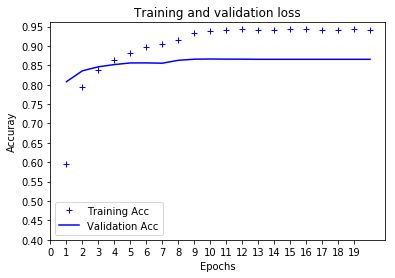

In [46]:
chart_acc(history_lstm)
chart_acc(history_dropout)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [42]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

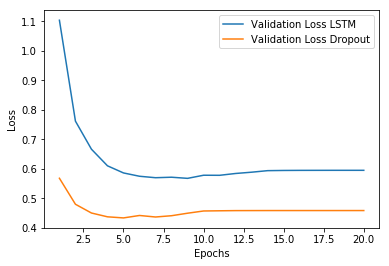

In [43]:
compare_loss({'LSTM': history_lstm, 'Dropout': history_dropout})

In [44]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

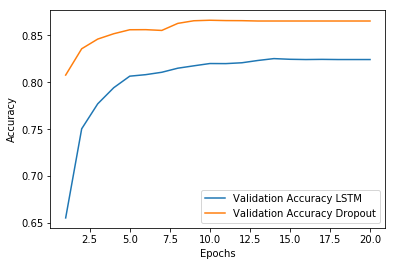

In [45]:
compare_accuracy({'LSTM': history_lstm, 'Dropout': history_dropout})

### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [48]:
model = build_model_lstm(64,64)

In [56]:
history = model.fit(x=np.concatenate([x_train_pad, x_val_pad]), y=np.concatenate([y_train, y_val]), 
                    epochs=2, batch_size=256)

Epoch 1/2
110434/110434 [==============================] - 123s 1ms/step - loss: 0.4443 - acc: 0.8429
Epoch 2/2
110434/110434 [==============================] - 122s 1ms/step - loss: 0.4193 - acc: 0.8518


In [57]:
loss, acc = model.evaluate(x_test_pad, y_test)

27609/27609 [==============================] - 78s 3ms/step


In [55]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.5725227301738803
acc 0.8059328479757174


## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
